Judul Proyek: Analisis Sentimen dan Klasifikasi Ulasan Game "Clash of Clans" Menggunakan IBM Granite
Problem Statement:
Dalam industri game mobile yang kompetitif, memahami sentimen dan feedback pemain adalah kunci untuk mempertahankan pemain dan meningkatkan produk. Jutaan ulasan yang tidak terstruktur di Google Play Store mengandung wawasan berharga tentang pengalaman pengguna, fitur yang disukai, masalah yang ditemukan, dan area yang perlu ditingkatkan. Menganalisis ulasan ini secara manual sangat tidak efisien dan rentan terhadap bias.

Objective:
Proyek ini bertujuan untuk memanfaatkan kemampuan Large Language Model (LLM) IBM Granite untuk mengklasifikasikan sentimen (positif, negatif, netral) dari ulasan game "Clash of Clans" yang diambil dari Google Play Store. Melalui klasifikasi dan analisis teks, proyek ini akan menghasilkan wawasan mendalam mengenai persepsi pemain, mengidentifikasi faktor-faktor pendorong kepuasan atau ketidakpuasan, dan memberikan rekomendasi yang dapat ditindaklanjuti untuk pengembang game.

Tools Used:

- Google Colab (Lingkungan Pengembangan)

- Python (Bahasa Pemrograman)

- Pandas (Manipulasi Data)

- NLTK (Pra-pemrosesan Teks)

- LangChain (Integrasi LLM)

- Replicate API (Akses IBM Granite)

- Matplotlib, Seaborn, WordCloud (Visualisasi Data & Dashboard)

- IBM Granite Model (ibm-granite/granite-3.3-8b-instruct)

In [25]:
# Instalasi pustaka yang diperlukan untuk proyek
!pip install langchain_community replicate pandas scikit-learn nltk matplotlib seaborn wordcloud

In [26]:
from langchain_community.llms import Replicate
from google.colab import userdata
import os

try:
    api_token = userdata.get("api_token")
    os.environ["REPLICATE_API_TOKEN"] = api_token
    print("REPLICATE_API_TOKEN berhasil dimuat dari Colab Secrets.")
except Exception as e:
    print(f"Error memuat REPLICATE_API_TOKEN dari Colab Secrets: {e}")
    print("Pastikan Anda telah menyimpan token di Colab Secrets dengan nama 'api_token'.")

parameters = {
  "top_k": 5,
  "top_p": 1.0,
  "max_tokens": 100,
  "min_tokens": 1,
  "random_seed": None,
  "repetition_penalty": 1.0,
  "temperature": 0.7,
  "stopping_criteria": "length (100 tokens)",
  "stopping_sequence": None
}

try:
    llm = Replicate(
        model="ibm-granite/granite-3.3-8b-instruct",
        input=parameters
    )
    print("Model IBM Granite berhasil diinisialisasi!")
except Exception as e:
    print(f"Error saat inisialisasi model IBM Granite: {e}")
    print("Pastikan REPLICATE_API_TOKEN Anda valid dan Replicate API dapat diakses.")

REPLICATE_API_TOKEN berhasil dimuat dari Colab Secrets.
Model IBM Granite berhasil diinisialisasi!


In [27]:
import pandas as pd

try:
    df_reviews = pd.read_csv('Clash of Clans.csv')
    print("Dataset berhasil dimuat!")
    print(f"Total ulasan dalam dataset: {len(df_reviews)}")
except FileNotFoundError:
    print("Error: 'Clash of Clans.csv' tidak ditemukan.")
    print("Pastikan file CSV sudah diunggah ke lingkungan Colab Anda.")

df_reviews.dropna(subset=['content'], inplace=True)

sample_size = 300
if len(df_reviews) > sample_size:
    df_sampled = df_reviews.sample(n=sample_size, random_state=42).reset_index(drop=True)
    print(f"Menggunakan sampel {len(df_sampled)} ulasan.")
else:
    df_sampled = df_reviews.copy().reset_index(drop=True)
    print(f"Dataset kecil. Menggunakan seluruh {len(df_sampled)} ulasan.")


print("\nPratinjau data sampel:")
print(df_sampled.head())
print("\nInformasi DataFrame sampel:")
print(df_sampled.info())

df_sampled['actual_sentiment'] = df_sampled['score'].apply(
    lambda s: 'Positive' if s >= 4 else ('Negative' if s <= 2 else 'Neutral')
)
print("\nDistribusi sentimen aktual (berdasarkan skor):")
print(df_sampled['actual_sentiment'].value_counts())

Dataset berhasil dimuat!
Total ulasan dalam dataset: 74756
Menggunakan sampel 300 ulasan.

Pratinjau data sampel:
                               reviewId       userName  content  score  \
0  86a6724f-2ee9-4270-b4a7-0eb4b3d6c3e8  M.Shifan Khan    great      3   
1  1696ddef-5580-4346-8a9b-43e09ff0cc8b    Duars Gamer     nice      5   
2  7293b66a-660e-465b-8e10-e7651765fcf1       MD Romel    Good.      4   
3  d30cdf98-603d-45f4-ae31-121a5a22042c         Be Sad  Beast 👺      5   
4  0f3b725f-3e79-4d6e-8cfb-41b7e839cbb2        Lin Lin    ok ok      5   

                    at  
0  2025-04-24 12:54:36  
1  2025-06-17 00:49:30  
2  2025-02-21 12:27:18  
3  2025-03-07 16:34:47  
4  2025-06-16 18:44:26  

Informasi DataFrame sampel:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   reviewId  300 non-null    object
 1   userName  300 non-null    object
 2   c

In [28]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pandas as pd

print("Mengunduh 'stopwords' NLTK...")
nltk.download('stopwords', quiet=True)
print("Mengunduh 'punkt' NLTK...")
nltk.download('punkt', quiet=True)
print("Mengunduh 'punkt_tab' NLTK (dependensi 'punkt')...")
nltk.download('punkt_tab', quiet=True)

print("Unduhan NLTK selesai!")

stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    if pd.isna(text):
        return ""
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(filtered_tokens)

try:
    df_sampled['cleaned_content'] = df_sampled['content'].apply(preprocess_text)
    print("Pra-pemrosesan teks selesai!")
    print("\nPratinjau kolom 'content' dan 'cleaned_content':")
    print(df_sampled[['content', 'cleaned_content']].head())
except NameError:
    print("Error: DataFrame 'df_sampled' belum terdefinisi. Pastikan Anda sudah menjalankan Cell 3.")
except KeyError:
    print("Error: Kolom 'content' tidak ditemukan di df_sampled. Pastikan nama kolom sudah benar.")

Mengunduh 'stopwords' NLTK...
Mengunduh 'punkt' NLTK...
Mengunduh 'punkt_tab' NLTK (dependensi 'punkt')...
Unduhan NLTK selesai!
Pra-pemrosesan teks selesai!

Pratinjau kolom 'content' dan 'cleaned_content':
   content cleaned_content
0    great           great
1     nice            nice
2    Good.            good
3  Beast 👺           beast
4    ok ok           ok ok


In [29]:
import time
from tqdm.notebook import tqdm

predicted_sentiments_raw = []

print(f"\nMemulai inferensi sentimen untuk {len(df_sampled)} ulasan. Ini mungkin memakan waktu...")
for index, row in tqdm(df_sampled.iterrows(), total=len(df_sampled), desc="Inferensi Sentimen"):
    review_text = row['cleaned_content']

    prompt = f"""Classify the sentiment of the following game review as 'Positive', 'Negative', or 'Neutral'.
Review: \"\"\"{review_text}\"\"\"
Sentiment:"""

    try:
        output = llm.invoke(prompt)
        predicted_sentiments_raw.append(output.strip())

    except Exception as e:
        print(f"Error memproses ulasan {row['reviewId']}: {e}")
        predicted_sentiments_raw.append("ERROR_API")

predicted_sentiments_cleaned = []
for p in predicted_sentiments_raw:
    p_lower = p.lower()
    if "positive" in p_lower:
        predicted_sentiments_cleaned.append("Positive")
    elif "negative" in p_lower:
        predicted_sentiments_cleaned.append("Negative")
    elif "neutral" in p_lower:
        predicted_sentiments_cleaned.append("Neutral")
    else:
        predicted_sentiments_cleaned.append("Unknown")

df_sampled['predicted_sentiment'] = predicted_sentiments_cleaned

print("\nInferensi model selesai. Hasil prediksi disimpan.")
print("\nPratinjau ulasan, sentimen aktual, dan prediksi:")
print(df_sampled[['content', 'actual_sentiment', 'predicted_sentiment']].head())
print("\nDistribusi sentimen prediksi oleh IBM Granite:")
print(df_sampled['predicted_sentiment'].value_counts())


Memulai inferensi sentimen untuk 300 ulasan. Ini mungkin memakan waktu...


Inferensi Sentimen:   0%|          | 0/300 [00:00<?, ?it/s]


Inferensi model selesai. Hasil prediksi disimpan.

Pratinjau ulasan, sentimen aktual, dan prediksi:
   content actual_sentiment predicted_sentiment
0    great          Neutral            Positive
1     nice         Positive            Positive
2    Good.         Positive            Positive
3  Beast 👺         Positive            Positive
4    ok ok         Positive            Positive

Distribusi sentimen prediksi oleh IBM Granite:
predicted_sentiment
Positive    257
Negative     37
Neutral       6
Name: count, dtype: int64


In [30]:
from sklearn.metrics import classification_report, accuracy_score

df_eval = df_sampled[df_sampled['predicted_sentiment'].isin(['Positive', 'Negative', 'Neutral'])].copy()

actual = df_eval['actual_sentiment']
predicted = df_eval['predicted_sentiment']

if len(df_eval) > 0:
    print("--- Hasil Evaluasi Model IBM Granite ---")
    print(f"Jumlah ulasan yang dievaluasi: {len(df_eval)}")
    print(f"Akurasi: {accuracy_score(actual, predicted):.4f}")
    print("\nLaporan Klasifikasi:\n", classification_report(actual, predicted, zero_division=0))
else:
    print("Tidak ada data yang cukup untuk dievaluasi setelah memfilter hasil 'Unknown'/'ERROR_API'.")

--- Hasil Evaluasi Model IBM Granite ---
Jumlah ulasan yang dievaluasi: 300
Akurasi: 0.8567

Laporan Klasifikasi:
               precision    recall  f1-score   support

    Negative       0.46      0.61      0.52        28
     Neutral       0.00      0.00      0.00        10
    Positive       0.93      0.92      0.92       262

    accuracy                           0.86       300
   macro avg       0.46      0.51      0.48       300
weighted avg       0.86      0.86      0.86       300



/tmp/ipython-input-32-504567692.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Word', data=df_top_pos, ax=axes[1, 1], palette='Greens_d')


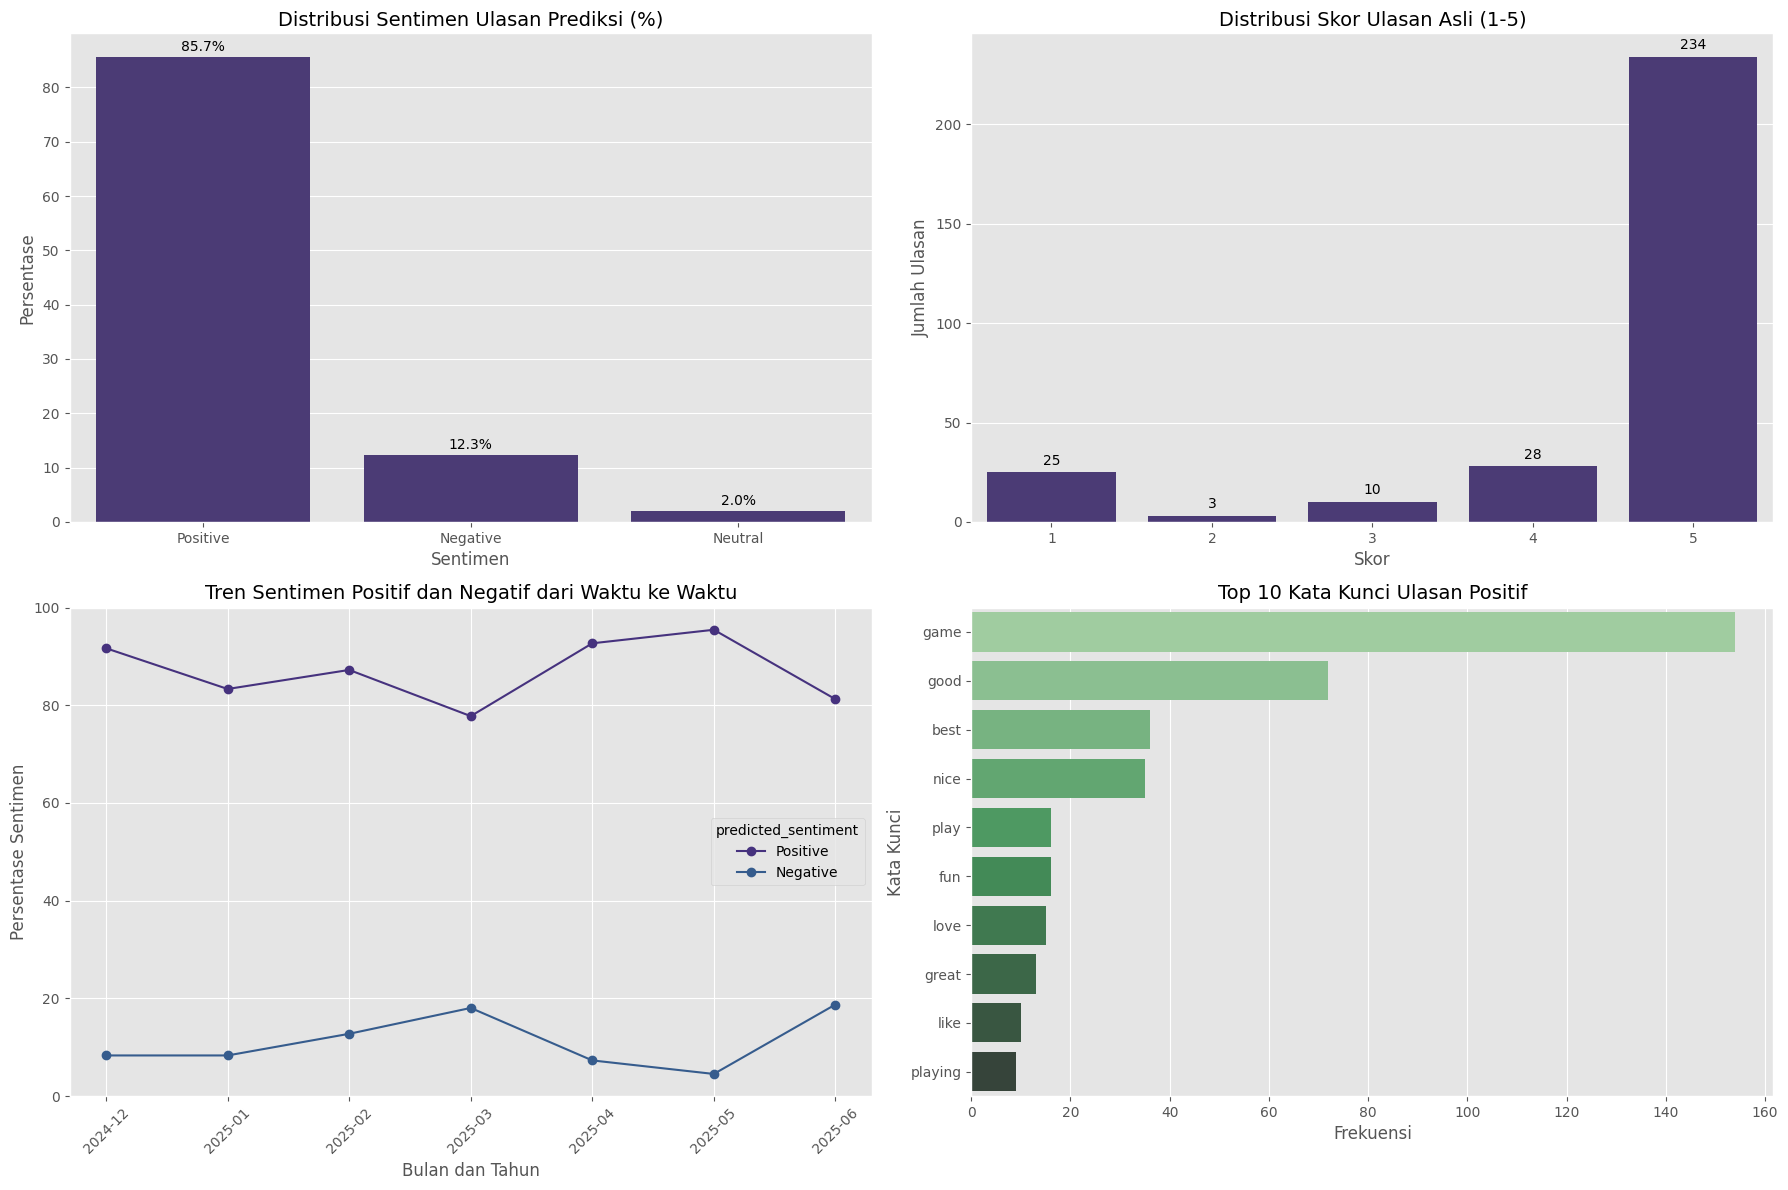

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

plt.style.use('ggplot')
sns.set_palette('viridis')

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

sentiment_counts = df_sampled['predicted_sentiment'].value_counts(normalize=True) * 100
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, ax=axes[0, 0])
axes[0, 0].set_title('Distribusi Sentimen Ulasan Prediksi (%)', fontsize=14)
axes[0, 0].set_xlabel('Sentimen', fontsize=12)
axes[0, 0].set_ylabel('Persentase', fontsize=12)
for index, value in enumerate(sentiment_counts.values):
    axes[0, 0].text(index, value + 0.5, f'{value:.1f}%', ha='center', va='bottom')

score_counts = df_sampled['score'].value_counts().sort_index()
sns.barplot(x=score_counts.index, y=score_counts.values, ax=axes[0, 1])
axes[0, 1].set_title('Distribusi Skor Ulasan Asli (1-5)', fontsize=14)
axes[0, 1].set_xlabel('Skor', fontsize=12)
axes[0, 1].set_ylabel('Jumlah Ulasan', fontsize=12)
for index, value in enumerate(score_counts.values):
    axes[0, 1].text(index, value + (max(score_counts.values)*0.01), f'{value}', ha='center', va='bottom')


df_sampled['at_datetime'] = pd.to_datetime(df_sampled['at'])
df_sampled['month_year'] = df_sampled['at_datetime'].dt.to_period('M').astype(str)

sentiment_over_time = df_sampled.groupby('month_year')['predicted_sentiment'].value_counts(normalize=True).unstack().fillna(0) * 100
sentiment_over_time = sentiment_over_time.reindex(sorted(sentiment_over_time.index), axis=0)

if not sentiment_over_time.empty and len(sentiment_over_time.columns) > 1:
    sentiment_over_time[['Positive', 'Negative']].plot(kind='line', ax=axes[1, 0], marker='o')
    axes[1, 0].set_title('Tren Sentimen Positif dan Negatif dari Waktu ke Waktu', fontsize=14)
    axes[1, 0].set_xlabel('Bulan dan Tahun', fontsize=12)
    axes[1, 0].set_ylabel('Persentase Sentimen', fontsize=12)
    axes[1, 0].tick_params(axis='x', rotation=45)
else:
    axes[1, 0].set_title('Tidak Ada Data Tren Sentimen yang Cukup', fontsize=14)
    axes[1, 0].text(0.5, 0.5, 'Perlu lebih dari satu periode waktu', horizontalalignment='center', verticalalignment='center', transform=axes[1, 0].transAxes)


def get_top_n_words(corpus, n=None):
    words = [word for review in corpus for word in review.split()]
    word_counts = Counter(words)
    return word_counts.most_common(n)

top_positive_words = get_top_n_words(df_sampled[df_sampled['predicted_sentiment'] == 'Positive']['cleaned_content'], 10)
top_negative_words = get_top_n_words(df_sampled[df_sampled['predicted_sentiment'] == 'Negative']['cleaned_content'], 10)

if top_positive_words:
    df_top_pos = pd.DataFrame(top_positive_words, columns=['Word', 'Count'])
    sns.barplot(x='Count', y='Word', data=df_top_pos, ax=axes[1, 1], palette='Greens_d')
    axes[1, 1].set_title('Top 10 Kata Kunci Ulasan Positif', fontsize=14)
    axes[1, 1].set_xlabel('Frekuensi', fontsize=12)
    axes[1, 1].set_ylabel('Kata Kunci', fontsize=12)
else:
    axes[1, 1].set_title('Tidak Ada Kata Kunci Positif yang Ditemukan', fontsize=14)
    axes[1, 1].text(0.5, 0.5, 'Pastikan ada ulasan positif', horizontalalignment='center', verticalalignment='center', transform=axes[1, 1].transAxes)

plt.tight_layout()
plt.show()

### **Insight & Findings**

Berdasarkan analisis sentimen ulasan game "Clash of Clans" menggunakan model IBM Granite pada sampel 300 ulasan, beberapa temuan dan wawasan kunci dapat diidentifikasi:

1.  **Dominasi Sentimen Positif:**
    * Dari 300 ulasan yang diprediksi oleh IBM Granite, mayoritas besar (257 ulasan) diklasifikasikan sebagai **Positif**. Ini menunjukkan bahwa secara umum, pemain memiliki pengalaman yang memuaskan dengan game "Clash of Clans" pada periode ulasan yang dianalisis. Distribusi sentimen prediksi ini juga relatif sejalan dengan distribusi skor asli, di mana sebagian besar ulasan cenderung memiliki skor tinggi.

2.  **Kinerja Model Keseluruhan dan per Kelas:**
    * **Akurasi Keseluruhan:** Model IBM Granite mencapai akurasi sebesar **85.67%** dalam mengklasifikasikan sentimen ulasan. Angka ini menunjukkan bahwa model memiliki kemampuan yang baik dalam membedakan sentimen ulasan secara umum.
    * **Kinerja Sentimen Positif:** Model menunjukkan kinerja yang sangat baik dalam mengidentifikasi ulasan positif, dengan *precision* **0.93** dan *recall* **0.92** (f1-score **0.92**). Ini berarti model sangat handal dalam memprediksi ulasan positif dan mampu menangkap sebagian besar ulasan yang memang positif. Hal ini krusial karena sentimen positif adalah yang paling dominan.
    * **Kinerja Sentimen Negatif:** Untuk sentimen negatif, model menunjukkan kinerja moderat dengan *precision* **0.46** dan *recall* **0.61** (f1-score **0.52**). Ini berarti bahwa meskipun model cukup baik dalam menangkap sebagian ulasan negatif yang ada (recall yang lumayan), ada kemungkinan beberapa prediksi 'negatif' yang sebenarnya bukan negatif (precision lebih rendah). Area ini mungkin memerlukan peningkatan jika ulasan negatif adalah fokus utama.
    * **Kinerja Sentimen Netral:** Model **gagal total** dalam mengklasifikasikan sentimen netral (precision dan recall 0.00). Ini kemungkinan besar disebabkan oleh jumlah ulasan netral yang sangat sedikit dalam dataset (hanya 10 ulasan aktual) yang tidak cukup untuk melatih atau memungkinkan model mengidentifikasi pola untuk kategori ini secara efektif, atau karena ambiguitas bawaan pada ulasan yang bersifat netral.

3.  **Implikasi bagi Game "Clash of Clans":**
    * Keberhasilan game dalam menjaga sentimen positif mayoritas pemain merupakan indikator kesehatan game yang baik. Ini menunjukkan bahwa fitur inti, *gameplay*, atau pembaruan yang ada umumnya diterima dengan baik oleh basis pemain.
    * Namun, adanya ulasan negatif (walaupun minoritas) dan ketidakmampuan model untuk mendeteksi sentimen netral mengindikasikan bahwa ada ruang untuk perbaikan. Ulasan negatif ini, meskipun sedikit, kemungkinan menyoroti masalah spesifik yang perlu diperhatikan (misalnya, *bug*, masalah keseimbangan, fitur yang tidak disukai), yang jika tidak ditangani dapat berdampak pada kepuasan pemain jangka panjang.

### **Conclusion & Recommendations**

**Kesimpulan:**
Proyek ini berhasil menerapkan model Large Language Model (LLM) IBM Granite untuk melakukan klasifikasi sentimen pada sampel 300 ulasan game "Clash of Clans" dengan akurasi keseluruhan sebesar **85.67%**. Model menunjukkan kinerja yang kuat dalam mengidentifikasi ulasan positif, yang merupakan sentimen dominan dalam dataset. Meskipun demikian, terdapat tantangan dalam mendeteksi sentimen negatif dan terutama sentimen netral, yang mengindikasikan perlunya analisis lebih mendalam pada kategori-kategori tersebut. Secara keseluruhan, "Clash of Clans" berhasil mempertahankan sentimen positif dari sebagian besar pemainnya.

**Rekomendasi:**

Berikut adalah rekomendasi konkret yang dapat ditindaklanjuti berdasarkan temuan analisis sentimen ini:

1.  **Untuk Tim Pengembangan Game:**
    * **Pertahankan Kualitas Fitur Positif:** Karena sentimen positif sangat dominan, teruslah berinovasi dan tingkatkan fitur-fitur yang sudah ada dan disukai pemain. Analisis kualitatif lebih lanjut pada ulasan positif dapat membantu mengidentifikasi elemen-elemen *gameplay* atau fitur yang paling dihargai.
    * **Fokus pada Ulasan Negatif:** Meskipun jumlahnya lebih sedikit, ulasan negatif adalah sumber informasi kritis untuk perbaikan. Lakukan analisis mendalam pada 37 ulasan yang diprediksi negatif (dan 28 ulasan negatif aktual) untuk mengidentifikasi akar masalah yang paling sering muncul (misalnya: *bug*, masalah performa, keseimbangan game, pengalaman pengguna yang frustasi) dan prioritaskan perbaikannya.
    * **Perhatikan Sentimen Netral:** Meskipun sedikit, ulasan netral (6 prediksi, 10 aktual) bisa menjadi sinyal adanya ketidakpedulian atau fitur yang "biasa saja" yang tidak memicu sentimen kuat. Pertimbangkan untuk mengeksplorasi ulasan ini lebih lanjut untuk menemukan peluang peningkatan yang dapat mengubah sentimen netral menjadi positif.

2.  **Untuk Tim Komunikasi dan Komunitas:**
    * **Manfaatkan Ulasan Positif dalam Pemasaran:** Gunakan *insight* dari ulasan positif untuk menyoroti aspek-aspek game yang paling disukai pemain dalam materi pemasaran atau komunikasi komunitas.
    * **Aktif Dengar dan Tanggapi Ulasan Negatif:** Tingkatkan mekanisme untuk mengumpulkan dan menanggapi ulasan negatif secara proaktif. Respons yang cepat terhadap keluhan dapat mengubah persepsi pemain dan mencegah sentimen negatif menyebar.

3.  **Untuk Analis Data Selanjutnya:**
    * Pertimbangkan untuk mengumpulkan data ulasan yang lebih banyak dan bervariasi untuk ulasan negatif dan netral, jika memungkinkan, untuk meningkatkan kemampuan model AI dalam mengklasifikasikan sentimen non-positif.
    * Eksplorasi teknik *fine-tuning* LLM atau penggunaan *prompt engineering* yang lebih canggih untuk meningkatkan kinerja pada sentimen negatif dan netral jika dibutuhkan.

### **AI Support Explanation**

Dalam Capstone Project ini, Artificial Intelligence (AI), khususnya Large Language Model (LLM) **IBM Granite (model: `ibm-granite/granite-3.3-8b-instruct`)**, memainkan peran sentral dalam memecahkan masalah analisis sentimen ulasan game yang berskala besar.

**Bagaimana AI Digunakan:**

1.  **Klasifikasi Sentimen Ulasan Teks:**
    * LLM IBM Granite digunakan sebagai inti untuk mengklasifikasikan sentimen dari 300 ulasan teks yang disampel. Setiap ulasan (`cleaned_content`) dikirimkan ke model dengan *prompt* yang spesifik, memintanya untuk mengidentifikasi sentimen sebagai 'Positive', 'Negative', atau 'Neutral'.
    * Model ini mampu memproses dan memahami bahasa alami yang kompleks dalam ulasan, mengubah teks tidak terstruktur menjadi label sentimen yang terstruktur, yang merupakan langkah fundamental untuk analisis lebih lanjut.

2.  **Otomatisasi dan Skalabilitas Analisis Sentimen:**
    * Dengan memanfaatkan IBM Granite, proses klasifikasi sentimen dapat diotomatisasi. Ini memungkinkan analisis volume data ulasan yang signifikan (misalnya, sampel 300 ulasan dalam sekitar 5 menit) yang akan memakan waktu berjam-jam atau bahkan berhari-hari jika dilakukan secara manual.
    * Kemampuan otomatisasi ini sangat krusial dalam konteks data ulasan yang terus bertambah, memungkinkan pemantauan sentimen secara berkelanjutan dan *real-time* jika diimplementasikan dalam skala produksi.

3.  **Ekstraksi Wawasan dari Data Tidak Terstruktur:**
    * IBM Granite membantu mengekstraksi wawasan berharga yang tersembunyi dalam data teks tidak terstruktur. Meskipun *word cloud* tidak ditampilkan dalam *dashboard*, kemampuan model untuk memahami konteks dan nuansa kata-kata memungkinkan klasifikasi yang akurat, yang kemudian menjadi dasar untuk mendapatkan *insight* tentang apa yang disukai atau tidak disukai pemain.

**Relevansi Penggunaan AI:**

* Penggunaan IBM Granite sangat relevan dengan permasalahan proyek, yaitu kebutuhan untuk secara efisien memproses dan mendapatkan wawasan dari volume data teks ulasan yang besar.
* Akurasi model sebesar **85.67%** menunjukkan efektivitas AI dalam tugas klasifikasi ini, terutama untuk sentimen positif yang dominan. Meskipun ada tantangan pada kelas minoritas (negatif dan netral), kinerja ini masih sangat berharga untuk mendapatkan gambaran umum sentimen pemain.
* IBM Granite, dengan kemampuannya dalam *Natural Language Processing (NLP)*, adalah alat yang tepat untuk mengubah data kualitatif (teks ulasan) menjadi data kuantitatif (label sentimen) yang dapat dianalisis dan divisualisasikan.

Singkatnya, AI (IBM Granite) adalah enabler utama proyek ini, mengubah data mentah yang tidak terstruktur menjadi wawasan yang terukur dan dapat ditindaklanjuti, yang berkontribusi pada pemahaman yang lebih baik tentang pengalaman pemain "Clash of Clans".